In [2]:
import pandas as pd # dataframe manipulation
import numpy as np # linear algebra

# data visualization
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import shap

# sklearn 
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, PowerTransformer, OrdinalEncoder
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, silhouette_samples, accuracy_score, classification_report
from sklearn.decomposition import PCA

from pyod.models.ecod import ECOD
from yellowbrick.cluster import KElbowVisualizer

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [3]:
data = pd.read_csv('./data/bike_buyers_clean.csv')

In [4]:
data

,ID,Marital Status,Gender,Income,Children,Education,Occupation,Home Owner,Cars,Commute Distance,Region,Age,Purchased Bike
0,12496,Married,Female,40000,1,Bachelors,Skilled Manual,Yes,0,0-1 Miles,Europe,42,No
1,24107,Married,Male,30000,3,Partial College,Clerical,Yes,1,0-1 Miles,Europe,43,No
2,14177,Married,Male,80000,5,Partial College,Professional,No,2,2-5 Miles,Europe,60,No
3,24381,Single,Male,70000,0,Bachelors,Professional,Yes,1,5-10 Miles,Pacific,41,Yes
4,25597,Single,Male,30000,0,Bachelors,Clerical,No,0,0-1 Miles,Europe,36,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,23731,Married,Male,60000,2,High School,Professional,Yes,2,2-5 Miles,North America,54,Yes
996,28672,Single,Male,70000,4,Graduate Degree,Professional,Yes,0,2-5 Miles,North America,35,Yes
997,11809,Married,Male,60000,2,Bachelors,Skilled Manual,Yes,0,0-1 Miles,North America,38,Yes
998,19664,Single,Male,100000,3,Bachelors,Management,No,3,1-2 Miles,North America,38,No


In [5]:
# Columns lists
categorical_cols = ['Marital Status', 'Gender', 'Occupation', 'Home Owner', 'Region', 'Purchased Bike']
ordinal_cols = ['Education', 'Commute Distance']
numerical_cols = ['Income', 'Children', 'Cars', 'Age']

# Create a transformer for each data type
# Transfomer for categorical data based on OHC
categorical_transformer = Pipeline(steps=[
    ("encoder", OneHotEncoder(handle_unknown="ignore", drop="first", sparse=False))
])

# Encoding of ordinal data
ordinal_transformer = Pipeline(steps=[
    ("encoder", OrdinalEncoder(categories=[['Partial High School', 'High School', 'Partial College', 'Bachelors', 'Graduate Degree'], 
                                           ['0-1 Miles', '1-2 Miles', '2-5 Miles', '5-10 Miles', '10+ Miles']])) 
])

# Powertransformer normalises data with the assumtption that data is normaly distributed
numerical_transformer = Pipeline(steps=[
    ("transformer", PowerTransformer())
])

# ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_cols),
        ('ord', ordinal_transformer, ordinal_cols),
        ('num', numerical_transformer, numerical_cols)
    ])

# Full pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])


pipeline.fit(data)
transformed_data = pipeline.transform(data)

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


In [6]:
# create a df from transformed data to have a better understanding of data
transformed_df = pd.DataFrame(transformed_data, columns = pipeline.fit(data).get_feature_names_out().tolist())
transformed_df

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


,cat__Marital Status_Single,cat__Gender_Male,cat__Occupation_Management,cat__Occupation_Manual,cat__Occupation_Professional,cat__Occupation_Skilled Manual,cat__Home Owner_Yes,cat__Region_North America,cat__Region_Pacific,cat__Purchased Bike_Yes,ord__Education,ord__Commute Distance,num__Income,num__Children,num__Cars,num__Age
0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,3.0,0.0,-0.394012,-0.390951,-1.441223,-0.067828
1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,-0.799762,0.771203,-0.277524,0.024350
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.831899,1.567855,0.581853,1.321997
3,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,3.0,3.0,0.564771,-1.340990,-0.277524,-0.162293
4,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,-0.799762,-1.340990,-1.441223,-0.673208
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,2.0,0.275895,0.260296,0.581853,0.913176
996,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,4.0,2.0,0.564771,1.197992,-1.441223,-0.784107
997,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,3.0,0.0,0.275895,0.260296,-1.441223,-0.460588
998,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,1.0,1.316118,0.771203,1.288811,-0.460588


In [7]:
# Outliers
detector = ECOD()
detector.fit(transformed_df)
outliers = detector.predict(transformed_df)
transformed_df['outliers'] = outliers

In [8]:
data_no_outliers = transformed_df[transformed_df['outliers']==0].drop(["outliers"], axis = 1)
data_with_outliers = transformed_df.copy().drop(["outliers"], axis = 1)

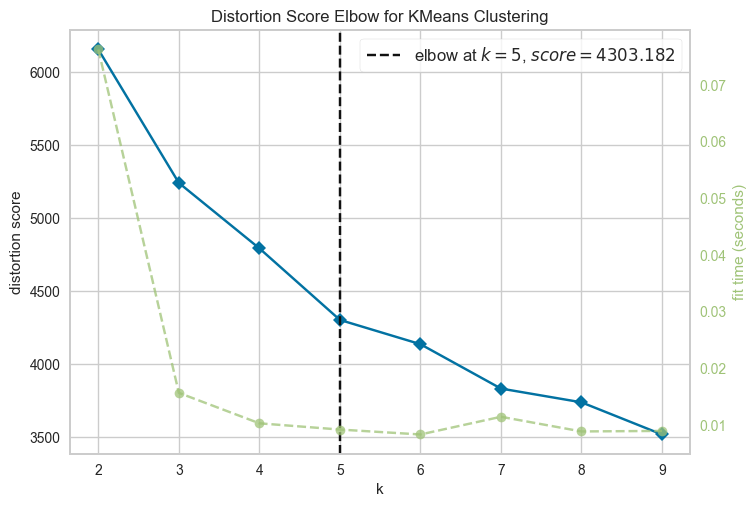

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [9]:
km = KMeans(init="k-means++", random_state=0, n_init="auto")
visualizer = KElbowVisualizer(km, k=(2,10))
 
visualizer.fit(data_no_outliers)
visualizer.show()

In [10]:
km = KMeans(n_clusters=5, init='k-means++', random_state=42, n_init = 10, max_iter=10000)
clusters = km.fit_predict(data_no_outliers)

In [11]:
clusters

array([0, 1, 4, 3, 0, 1, 0, 4, 1, 1, 1, 1, 1, 1, 0, 1, 4, 0, 0, 1, 0, 1,
       3, 4, 1, 1, 3, 2, 4, 1, 3, 3, 1, 1, 4, 0, 1, 0, 4, 4, 1, 0, 1, 0,
       4, 3, 4, 0, 0, 2, 1, 1, 0, 4, 0, 4, 0, 3, 1, 2, 3, 1, 3, 2, 4, 0,
       1, 0, 3, 4, 2, 2, 3, 1, 1, 1, 2, 3, 4, 4, 1, 0, 0, 1, 1, 2, 1, 4,
       4, 3, 4, 1, 0, 0, 1, 3, 1, 0, 0, 1, 2, 3, 4, 4, 0, 2, 3, 0, 1, 1,
       2, 4, 0, 4, 1, 1, 3, 1, 4, 4, 0, 0, 3, 0, 1, 0, 0, 4, 3, 4, 2, 1,
       2, 1, 1, 1, 0, 4, 1, 0, 1, 2, 3, 0, 2, 0, 4, 4, 0, 0, 1, 1, 4, 2,
       1, 4, 1, 4, 1, 4, 0, 2, 0, 3, 0, 4, 4, 0, 4, 0, 1, 2, 0, 3, 0, 4,
       4, 0, 4, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 4, 3, 0, 1, 0, 3, 4,
       2, 3, 2, 3, 4, 0, 0, 0, 1, 0, 1, 4, 0, 1, 4, 4, 0, 1, 3, 1, 3, 0,
       0, 1, 1, 0, 1, 1, 4, 1, 4, 2, 0, 4, 1, 0, 0, 1, 3, 0, 0, 4, 4, 0,
       0, 0, 2, 4, 0, 1, 1, 1, 2, 4, 4, 4, 2, 3, 4, 0, 0, 0, 1, 0, 0, 1,
       0, 1, 3, 1, 4, 4, 2, 1, 1, 4, 0, 3, 3, 1, 3, 3, 0, 0, 1, 1, 1, 1,
       4, 0, 0, 3, 1, 4, 3, 1, 0, 2, 1, 0, 0, 4, 4,

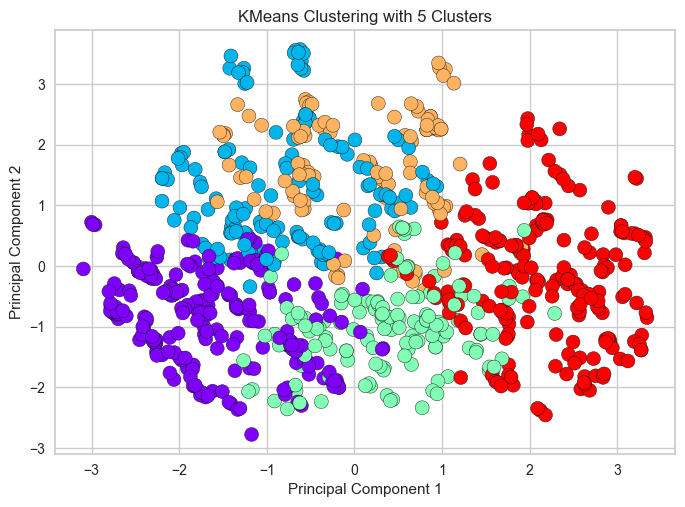

In [12]:
## PCA to reduce dimesnions and visualise clusters differentiation
import matplotlib.pyplot as plt

# Reduce data to 2D
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_no_outliers)

# Plot
plt.scatter(data_pca[:, 0], data_pca[:, 1], c=clusters, cmap='rainbow', edgecolor='k', s=100)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('KMeans Clustering with 5 Clusters')
plt.show()


In [15]:
pca.explained_variance_ratio_

array([0.29435998, 0.19958618])

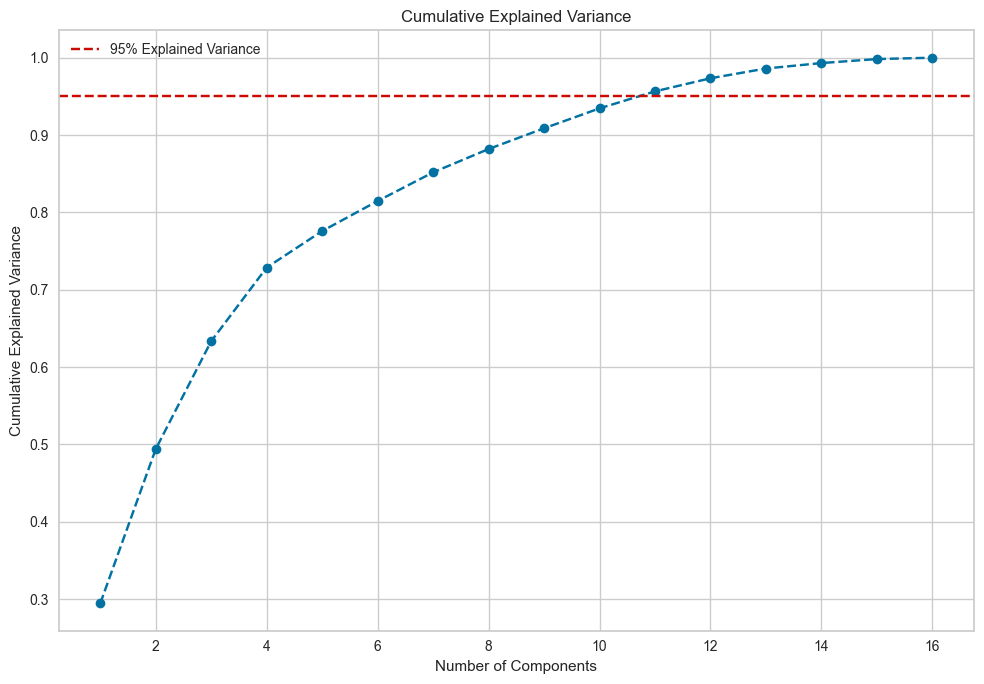

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Assuming your data is in a variable called `data`
pca = PCA().fit(data_no_outliers)

# Calculate cumulative sum of explained variances
cum_sum = np.cumsum(pca.explained_variance_ratio_)

# Plot
plt.figure(figsize=(10, 7))
plt.plot(range(1, len(cum_sum) + 1), cum_sum, marker='o', linestyle='--')
plt.title("Cumulative Explained Variance")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid(True)
plt.axhline(y=0.95, color='r', linestyle='--', label="95% Explained Variance")
plt.legend(loc="best")
plt.tight_layout()
plt.show()

Text(0.5, 0, 'Principal Component 3')

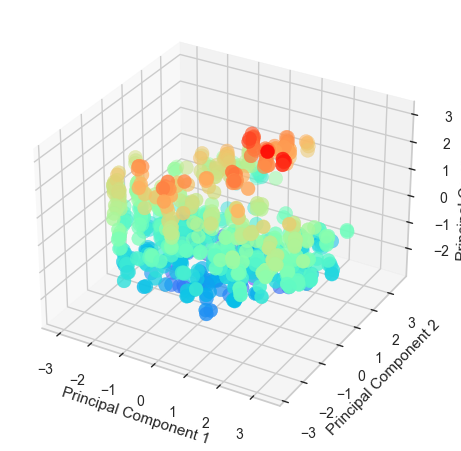

In [17]:
## PCA to reduce dimensions and visualise clusters differentiation
import matplotlib.pyplot as plt

# Reduce data to 3D
pca = PCA(n_components=3)
data_pca = pca.fit_transform(data_no_outliers)

# 3D-Plot
graph = plt.figure()
axis = graph.add_subplot(projection="3d")
xdata = data_pca[:, 0]
ydata = data_pca[:, 1]
zdata = data_pca[:, 2]
axis.scatter3D(xdata, ydata, zdata, c=zdata, cmap = "rainbow", s=100)
axis.set_xlabel("Principal Component 1")
axis.set_ylabel("Principal Component 2")
axis.set_zlabel("Principal Component 3")